# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Clustering](#Clustering)
    - [4-Seam Fastball](#4-Seam-Fastball)
        - [4-Seam Cluster Label](#Cluster-Labels---4-Seam)
    - [Slider](#Slider)
        - [Slider Cluster Label](#Cluster-Labels---Slider)
    - [Changeup](#Changeup)
        - [Changeup Cluster Label](#Cluster-Labels---Changeup)
    - [Cutter](#Cutter)
        - [Cutter Cluster Label](#Cluster-Labels---Cutter)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, k_means
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Data

In [3]:
data = pd.read_csv('../data/mlb-pitches.csv')
data.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'], inplace = True) 

pd.set_option('max_columns', None)
print(data.shape)
data.head(3)

(708653, 76)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,zone,des,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,fielder_2,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,post_away_score,post_home_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bauer_units,is_strike,pitch_count,swing_miss,plate_-x,pfx_-x
0,FF,2021-10-03,92.3,1.40,6.80,"Smith, Will",596019,519293,out,hit_into_play,1.0,"Francisco Lindor grounds out, third baseman Eh...",R,L,ATL,NYM,X,5.0,ground_ball,1,2,2021,8.28,16.56,-0.69,2.83,NaN,NaN,NaN,2,9,Top,77.54,155.31,518595.0,-6.833043,-134.166485,-7.361843,9.708393,26.562803,-14.083224,3.32,1.51,13.0,95.2,-13.0,92.8,2330.0,6.5,632254,54.03,0.174,0.158,0.0,1.0,0.0,0.0,2.0,61,4,4-Seam Fastball,5,0,0,5,Infield shift,Strategic,148.0,0.0,-0.073,25.243770,1,1-2,0,0.69,-8.28
1,SL,2021-10-03,80.6,1.60,6.64,"Smith, Will",596019,519293,NaN,foul,4.0,"Francisco Lindor grounds out, third baseman Eh...",R,L,ATL,NYM,S,NaN,NaN,1,1,2021,-9.24,5.76,-0.71,2.62,NaN,NaN,NaN,2,9,Top,NaN,NaN,518595.0,-3.700232,-117.430885,-3.266842,-6.531123,19.793390,-27.369114,3.32,1.51,108.0,75.3,75.0,81.2,2254.0,6.4,632254,54.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,3,Slider,5,0,0,5,Infield shift,Strategic,315.0,0.0,-0.027,27.965261,1,1-1,0,0.71,9.24
2,CU,2021-10-03,75.5,1.46,6.88,"Smith, Will",596019,519293,NaN,foul,5.0,"Francisco Lindor grounds out, third baseman Eh...",R,L,ATL,NYM,S,NaN,NaN,1,0,2021,-7.80,-6.12,-0.04,2.46,NaN,NaN,NaN,2,9,Top,NaN,NaN,518595.0,-1.977183,-109.901781,-1.155694,-4.872924,20.602334,-36.262184,3.32,1.51,157.0,83.5,65.0,75.2,1940.0,6.2,632254,54.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,2,Curveball,5,0,0,5,Infield shift,Standard,328.0,0.0,-0.020,25.695364,1,1-0,0,0.04,7.80


# Preprocessing

### Multicolinearity - VIF

In [3]:
features = data.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns

vif_data["VIF"] = [variance_inflation_factor(features.values, i)
                   for i in range(len(features.columns))]

vif_data.sort_values(by = 'VIF').head(11)

,feature,VIF
9,pa,1.341585
1,pitch_usage,1.690136
0,pitch_type,2.240690
19,hard_hit_percent,2.851798
15,put_away,4.291064
13,whiff_percent,4.617305
8,run_value,5.538815
7,run_value_per_100,7.206740
14,k_percent,8.649346
4,movement_inches,16.037129


# Clustering 

## 4-Seam Fastball

In [4]:
features_ff = ff.select_dtypes([np.number])
X_ff = features_ff

ss = StandardScaler()
X_ff_scaled = ss.fit_transform(X_ff)
X_ff_scaled[:,:] *= -1

pca = PCA().fit(X_ff_scaled)
principal_components_ff = pca.transform(X_ff_scaled)
model_ff = pd.DataFrame(data = principal_components_ff, columns = X_ff.columns)

km_ff = KMeans(n_clusters = 2, 
               random_state = 1)
km_ff.fit(model_ff)
label_ff = km_ff.fit_predict(model_ff)

print('Number of iterations:', km_ff.n_iter_)
print('Number of features:', km_ff.n_features_in_)
print('Number of clusters:', km_ff.n_clusters)
print('Inertia:', km_ff.inertia_, '\n')
print("Predicted clusters to points: ", label_ff[:10], '\n')
#centroids = km_ff.cluster_centers_
#print("Location of centroids: ")
#print(centroids)

Number of iterations: 7
Number of features: 23
Number of clusters: 2
Inertia: 6563.44413649166 

Predicted clusters to points:  [0 1 1 1 0 1 1 0 0 0] 



### Cluster Labels - 4-Seam

In [5]:
X_ff['label'] = label_ff
model_ff['label'] = label_ff
#model_ff.groupby(by = 'label').mean().T
X_ff.groupby(by = 'label').mean().T

label,0,1
pitch_type,1.000000,1.000000
pitch_usage,43.845143,49.408411
release_speed,93.255429,94.177570
spin_rate,2236.702857,2303.168224
movement_inches,17.320571,17.989252
spin_eff%,89.800000,89.859813
active_spin,0.897941,0.898768
run_value_per_100,0.916571,-0.694393
run_value,3.874286,-4.228972
pa,127.365714,149.546729


## Slider

In [6]:
features_sl = sl.select_dtypes([np.number])
X_sl = features_sl

X_sl_scaled = ss.fit_transform(X_sl)
X_sl_scaled[:,:] *= -1

pca = PCA().fit(X_sl_scaled)
principal_components_sl = pca.transform(X_sl_scaled)
model_sl = pd.DataFrame(data = principal_components_sl, columns = X_sl.columns)

km_sl = KMeans(n_clusters = 2, 
               random_state = 1)

km_sl.fit(model_sl)
label_sl = km_sl.fit_predict(model_sl)

print('Number of iterations:', km_sl.n_iter_)
print('Number of features:', km_sl.n_features_in_)
print('Number of clusters:', km_sl.n_clusters)
print('Inertia:', km_sl.inertia_, '\n')
print("Predicted clusters to points: ", label_sl[:10], '\n')

Number of iterations: 10
Number of features: 23
Number of clusters: 2
Inertia: 4244.390572658353 

Predicted clusters to points:  [0 1 0 1 1 0 0 1 0 0] 



### Cluster Labels - Slider

In [7]:
X_sl['label'] = label_sl
model_sl['label'] = label_sl

X_sl.groupby(by = 'label').mean().T

label,0,1
pitch_type,2.000000,2.000000
pitch_usage,28.982031,35.265625
release_speed,84.442969,84.846094
spin_rate,2370.906250,2476.359375
movement_inches,7.346875,9.587500
spin_eff%,34.218750,38.898438
active_spin,0.342528,0.389190
run_value_per_100,0.589063,-1.462500
run_value,1.757812,-5.851562
pa,104.945312,109.742188


## Changeup

In [8]:
features_ch = ch.select_dtypes([np.number])
X_ch = features_ch

X_ch_scaled = ss.fit_transform(X_ch)
X_ch_scaled[:,:] *= -1

pca = PCA().fit(X_ch_scaled)
principal_components_ch = pca.transform(X_ch_scaled)
model_ch = pd.DataFrame(data = principal_components_ch, columns = X_ch.columns)

km_ch = KMeans(n_clusters = 2, 
               random_state = 1)

km_ch.fit(model_ch)
label_ch = km_ch.fit_predict(model_ch)

print('Number of iterations:', km_ch.n_iter_)
print('Number of features:', km_ch.n_features_in_)
print('Number of clusters:', km_ch.n_clusters)
print('Inertia:', km_ch.inertia_, '\n')
print("Predicted clusters to points: ", label_ch[:10], '\n')

Number of iterations: 5
Number of features: 23
Number of clusters: 2
Inertia: 2114.929241648285 

Predicted clusters to points:  [1 0 1 1 1 0 0 0 1 0] 



### Cluster Labels - Changeup

In [9]:
X_ch['label'] = label_ch
model_ch['label'] = label_ch

X_ch.groupby(by = 'label').mean().T

label,0,1
pitch_type,3.000000,3.000000
pitch_usage,27.203125,20.951667
release_speed,84.900000,84.393333
spin_rate,1808.531250,1694.183333
movement_inches,16.732813,15.711667
spin_eff%,90.859375,89.400000
active_spin,0.909695,0.894793
run_value_per_100,-0.982812,0.990000
run_value,-4.031250,3.550000
pa,120.062500,109.933333


## Cutter

In [10]:
features_fc = fc.select_dtypes([np.number])
X_fc = features_fc

X_fc_scaled = ss.fit_transform(X_fc)
X_fc_scaled[:,:] *= -1

pca = PCA().fit(X_fc_scaled)
principal_components_fc = pca.transform(X_fc_scaled)
model_fc = pd.DataFrame(data = principal_components_fc, columns = X_fc.columns)

km_fc = KMeans(n_clusters = 2, 
               random_state = 1)

km_fc.fit(model_fc)
label_fc = km_fc.fit_predict(model_fc)

print('Number of iterations:', km_fc.n_iter_)
print('Number of features:', km_fc.n_features_in_)
print('Number of clusters:', km_fc.n_clusters)
print('Inertia:', km_fc.inertia_, '\n')
print("Predicted clusters to points: ", label_fc[:10], '\n')

Number of iterations: 7
Number of features: 23
Number of clusters: 2
Inertia: 1322.2351294584519 

Predicted clusters to points:  [1 0 1 0 0 0 1 1 0 1] 



### Cluster Labels - Cutter

In [11]:
X_fc['label'] = label_fc
model_fc['label'] = label_fc

X_fc.groupby(by = 'label').mean().T

label,0,1
pitch_type,4.000000,4.000000
pitch_usage,28.228571,35.726316
release_speed,87.980952,88.915789
spin_rate,2291.952381,2451.263158
movement_inches,8.916667,8.081579
spin_eff%,51.523810,42.500000
active_spin,0.515399,0.425604
run_value_per_100,0.783333,-1.126316
run_value,3.000000,-5.263158
pa,123.476190,117.105263


# Modeling

## Logistic Regression - 4-Seam

### Heatmaps of Features - 4-Seam

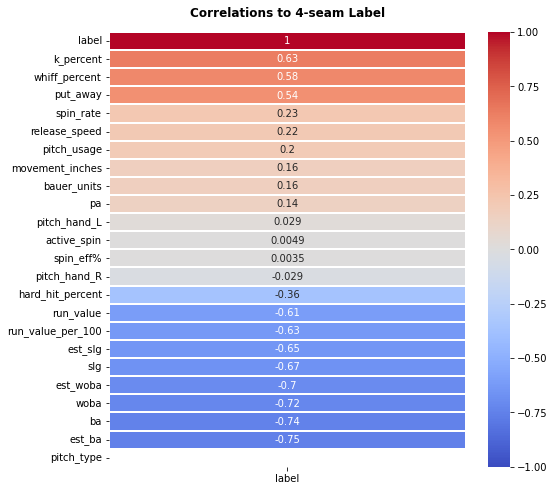

In [12]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_ff.corr()[['label']].sort_values(('label'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to 4-seam Label', fontweight = 'bold', pad = 15);

Positively correlated with label

Negatively correlated with lablel so the better the negatives the lower the run value / 100

In [13]:
X = X_ff.drop(columns = ['label'])
y = X_ff['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

pred_ff = lr.predict(X_test)
pred_probs_ff = lr.predict_proba(X_test)[:,1]

print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', round(cross_val_score(lr, X_train, y_train).mean(), 4))

Train score: 0.93
Test score: 0.89
Cross val score 0.9277


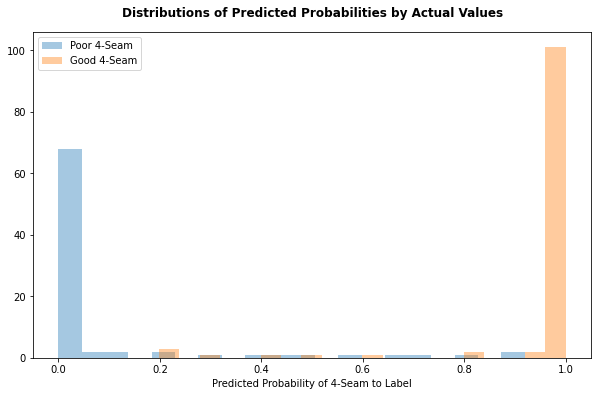

In [14]:
pred_ff_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_probs_ff})
labels = ('Poor 4-Seam', 'Good 4-Seam')
plt.figure(figsize = (10, 6))
for group in pred_ff_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20)
plt.xlabel('Predicted Probability of 4-Seam to Label')
plt.legend(labels)
plt.title('Distributions of Predicted Probabilities by Actual Values', fontweight = 'bold', pad = 15);

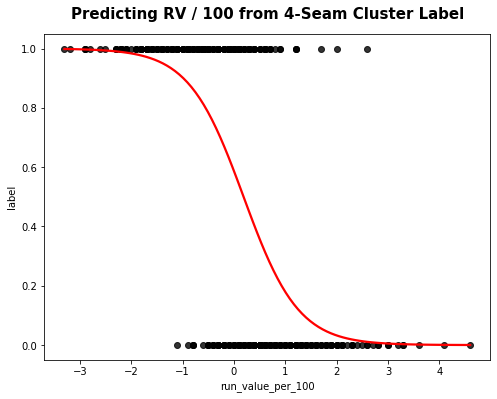

In [15]:
plt.figure(figsize = (8, 6))
sns.regplot(x = X_ff['run_value_per_100'], y = X_ff['label'], data = X_ff, logistic = True, ci = None,
            scatter_kws = {'color': 'black'}, line_kws = {'color': 'red'})
plt.title('Predicting RV / 100 from 4-Seam Cluster Label', fontweight = 'bold', fontsize = 15, pad = 15);

## Logistic Regression - Slider

### Heatmap of Features - Slider

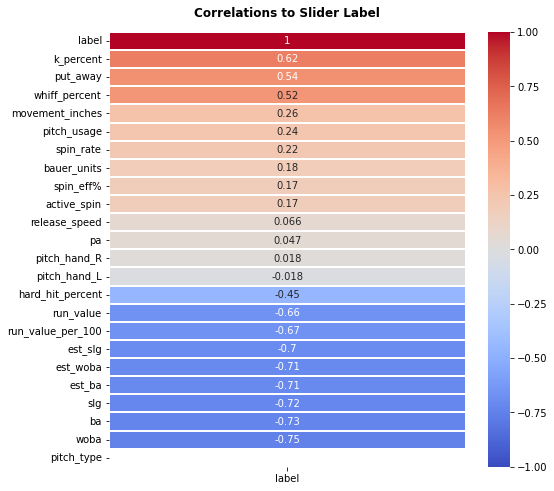

In [16]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_sl.corr()[['label']].sort_values(('label'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Slider Label', fontweight = 'bold', pad = 15);

In [17]:
X = X_sl.drop(columns = ['label'])
y = X_sl['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

pred_sl = lr.predict(X_test)
pred_probs_sl = lr.predict_proba(X_test)[:,1]

print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', round(cross_val_score(lr, X_train, y_train).mean(), 4))

Train score: 0.93
Test score: 0.92
Cross val score 0.9165


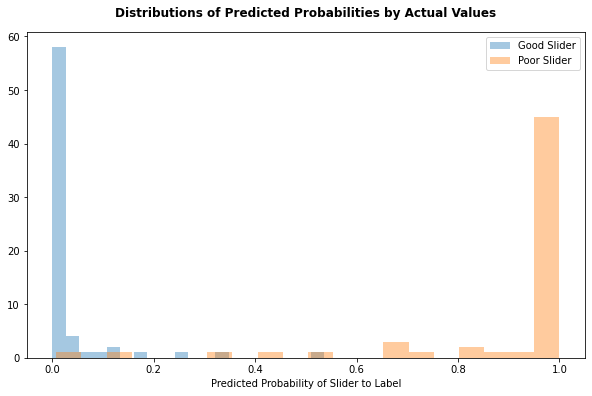

In [18]:
pred_sl_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_probs_sl})
labels = ('Good Slider', 'Poor Slider')
plt.figure(figsize = (10, 6))
for group in pred_sl_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20)
plt.xlabel('Predicted Probability of Slider to Label')
plt.legend(labels)
plt.title('Distributions of Predicted Probabilities by Actual Values', fontweight = 'bold', pad = 15);

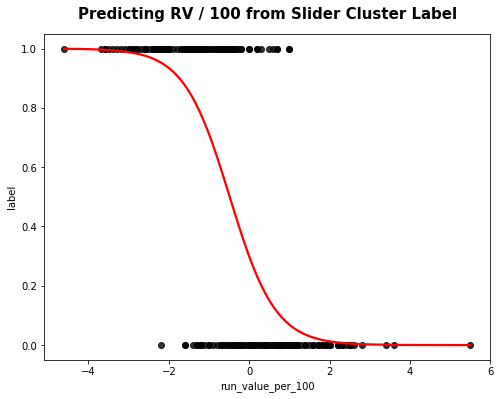

In [19]:
plt.figure(figsize = (8, 6))
sns.regplot(x = X_sl['run_value_per_100'], y = X_sl['label'], data = X_sl, logistic = True, ci = None,
            scatter_kws = {'color': 'black'}, line_kws = {'color': 'red'})
plt.title('Predicting RV / 100 from Slider Cluster Label', fontweight = 'bold', fontsize = 15, pad = 15);

## Logistic Regression - Changeup

### Heatmap of Features - Changeup

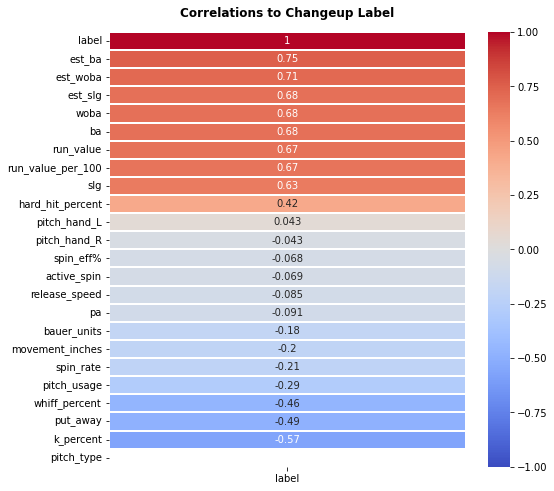

In [20]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_ch.corr()[['label']].sort_values(('label'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Changeup Label', fontweight = 'bold', pad = 15);

In [21]:
X = X_ch.drop(columns = ['label'])
y = X_ch['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

pred_ch = lr.predict(X_test)
pred_probs_ch = lr.predict_proba(X_test)[:,1]

print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', round(cross_val_score(lr, X_train, y_train).mean(), 4))

Train score: 0.95
Test score: 0.9
Cross val score 0.8912


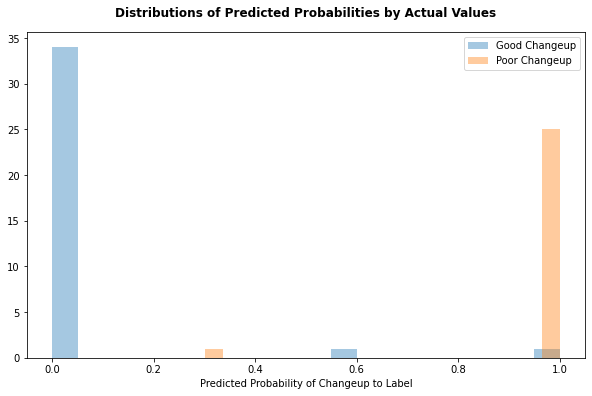

In [22]:
pred_ch_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_probs_ch})
labels = ('Good Changeup', 'Poor Changeup')
plt.figure(figsize = (10, 6))
for group in pred_ch_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20)
plt.xlabel('Predicted Probability of Changeup to Label');
plt.legend(labels)
plt.title('Distributions of Predicted Probabilities by Actual Values', fontweight = 'bold', pad = 15);

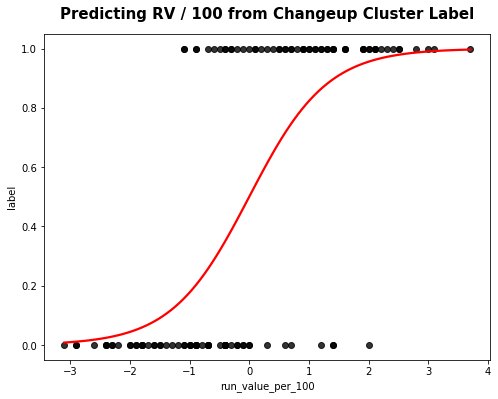

In [23]:
plt.figure(figsize = (8, 6))
sns.regplot(x = X_ch['run_value_per_100'], y = X_ch['label'], data = X_ch, logistic = True, ci = None,
            scatter_kws = {'color': 'black'}, line_kws = {'color': 'red'})
plt.title('Predicting RV / 100 from Changeup Cluster Label', fontweight = 'bold', fontsize = 15, pad = 15);

## Logistic Regression - Cutter

### Heatmap of Features - Cutter

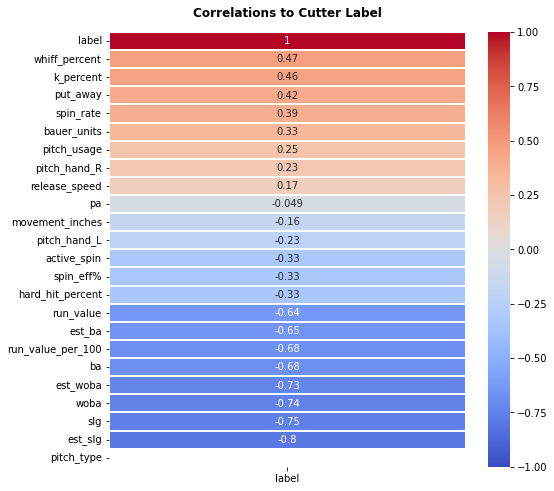

In [24]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_fc.corr()[['label']].sort_values(('label'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Cutter Label', fontweight = 'bold', pad = 15);

In [25]:
X = X_fc.drop(columns = ['label'])
y = X_fc['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

pred_fc = lr.predict(X_test)
pred_probs_fc = lr.predict_proba(X_test)[:,1]

print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', round(cross_val_score(lr, X_train, y_train).mean(), 4))

Train score: 0.98
Test score: 0.75
Cross val score 0.8333


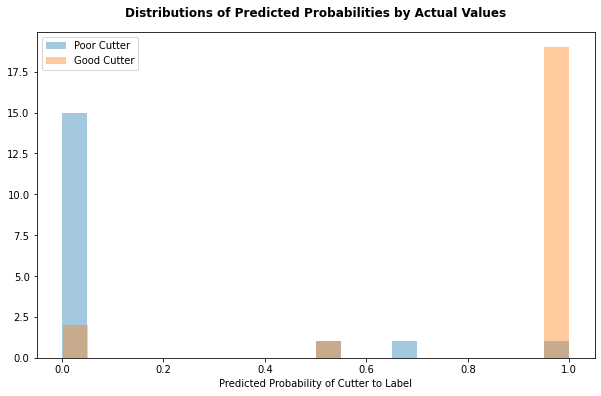

In [26]:
pred_fc_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_probs_fc})
labels = ('Poor Cutter', 'Good Cutter')
plt.figure(figsize = (10, 6))
for group in pred_fc_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20)
plt.xlabel('Predicted Probability of Cutter to Label')
plt.legend(labels)
plt.title('Distributions of Predicted Probabilities by Actual Values', fontweight = 'bold', pad = 15);

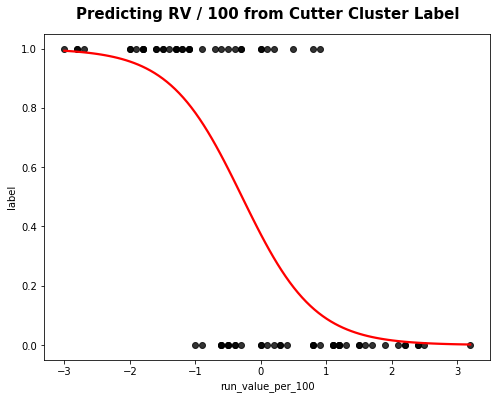

In [27]:
plt.figure(figsize = (8, 6))
sns.regplot(x = X_fc['run_value_per_100'], y = X_fc['label'], data = X_fc, logistic = True, ci = None,
            scatter_kws = {'color': 'black'}, line_kws = {'color': 'red'})
plt.title('Predicting RV / 100 from Cutter Cluster Label', fontweight = 'bold', fontsize = 15, pad = 15);